# 1. read data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *

In [2]:
ba_mcad = anndata.read_h5ad("../../02.clustering/02.5K/OP.All.TSNE.mcad")
ba_meta = pd.read_csv('../../02.clustering/02.5K/cell2cluster.csv')
ba_mcad = ba_mcad[ba_meta['cell'].to_list()]

In [3]:
ctrl_mcad = anndata.read_h5ad("../../../07.Ctrl/HIVpre_Flupre_Ctrl.withTSNE.h5ad")
ctrl_meta = pd.read_csv("../../../07.Ctrl/ControlCell2cluster.csv")
ctrl_mcad = ctrl_mcad[ctrl_meta['cell'].to_list()]

/tmp/ipykernel_1695876/1920901670.py:2: DtypeWarning: Columns (2,42,43,44,45,50,51,52,53,55,56,58,60,62,64,65,66,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  ctrl_meta = pd.read_csv("../../../07.Ctrl/ControlCell2cluster.csv")


In [4]:
mcad = anndata.concat([ba_mcad, ctrl_mcad])

In [5]:
id2cohort = dict(zip(ba_mcad.obs.index, ba_mcad.obs['Level']))

In [6]:
mcad.obs['Level'] = [id2cohort[x] if x in id2cohort else 'Ctrl' for x in mcad.obs.index]

# 2.0 Clustering

In [7]:
pc_cutoff = 0.1

resolution = 1

In [8]:
lsi(mcad, algorithm='arpack', obsm='X_pca')
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=False)
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()

33 components passed P cutoff of 0.1.


In [9]:
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:, :32]
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

# T-SNE

In [10]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [11]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [12]:
mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

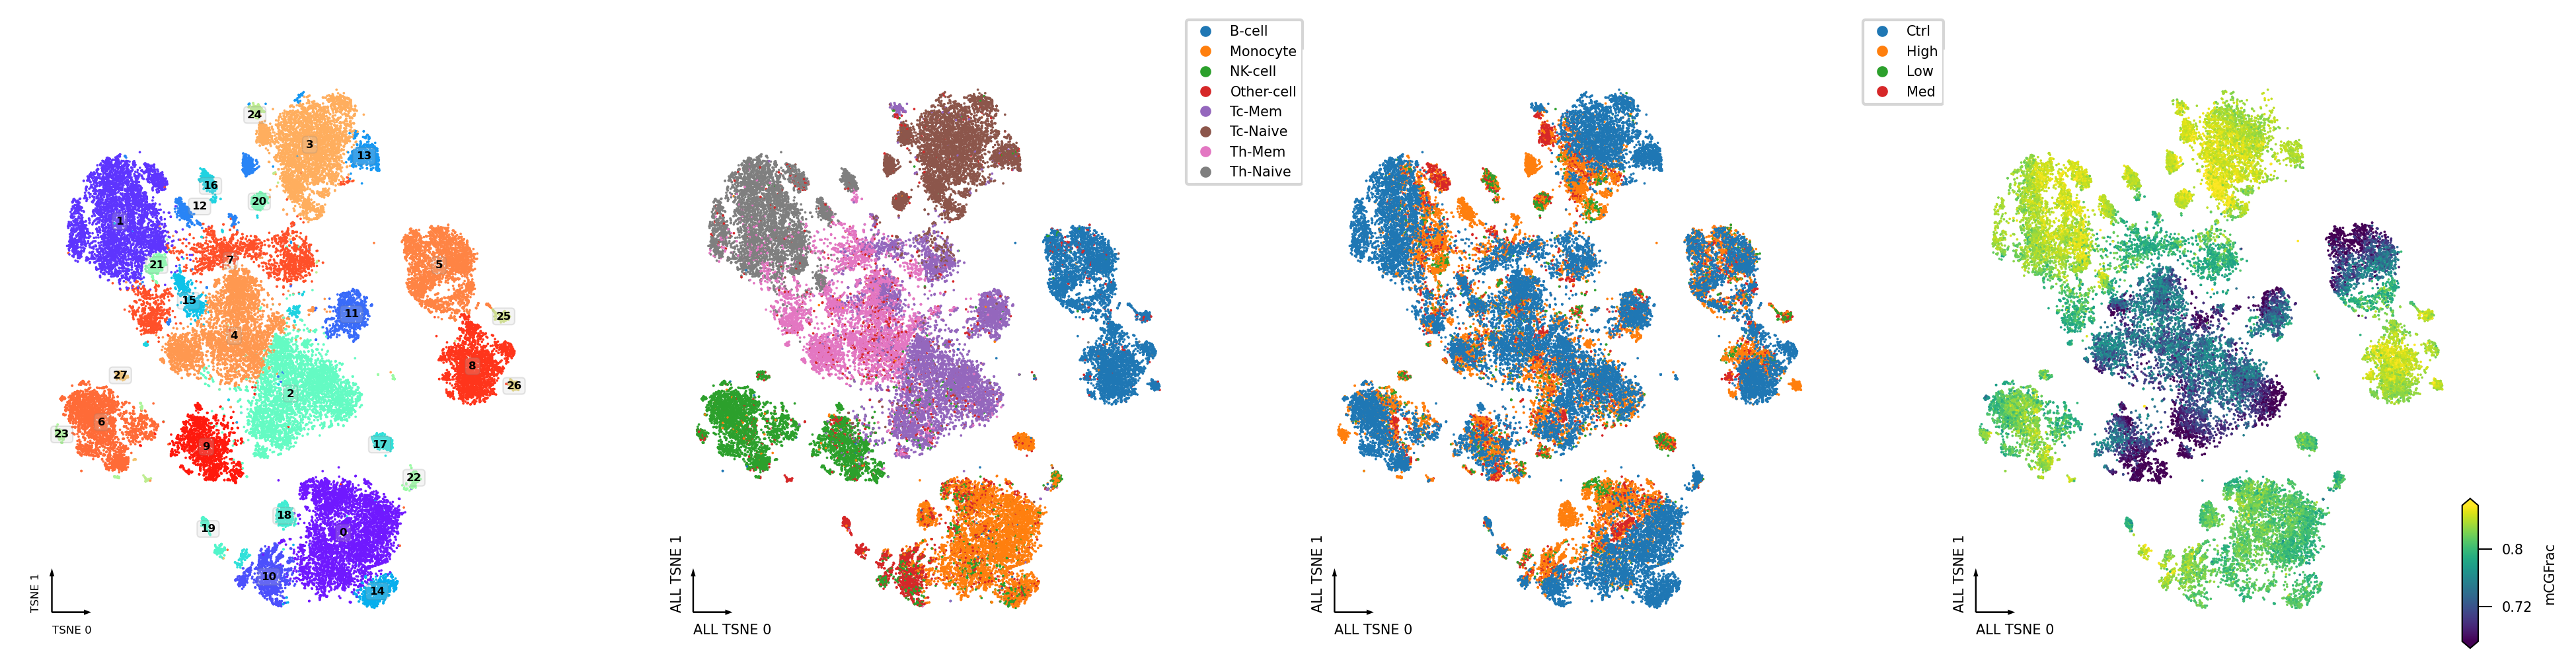

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='all_tsne', hue='Level', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='all_tsne', hue='mCGFrac', labelsize=5)


# 3.0 Harmony

In [16]:
import scanpy.external as sce

In [17]:
sce.pp.harmony_integrate(mcad, ['sampleID'], max_iter_harmony=30, random_state=0)
mcad.obsm['5kCG_u30hm'] = mcad.obsm['X_pca_harmony'].copy()

2022-10-26 17:45:40,481 - harmonypy - INFO - Iteration 1 of 30
2022-10-26 17:48:06,145 - harmonypy - INFO - Iteration 2 of 30
2022-10-26 17:50:36,276 - harmonypy - INFO - Iteration 3 of 30
2022-10-26 17:52:36,321 - harmonypy - INFO - Iteration 4 of 30
2022-10-26 17:54:34,205 - harmonypy - INFO - Iteration 5 of 30
2022-10-26 17:56:34,213 - harmonypy - INFO - Iteration 6 of 30
2022-10-26 17:58:18,874 - harmonypy - INFO - Iteration 7 of 30
2022-10-26 17:59:57,813 - harmonypy - INFO - Iteration 8 of 30
2022-10-26 18:01:32,125 - harmonypy - INFO - Iteration 9 of 30
2022-10-26 18:03:08,131 - harmonypy - INFO - Iteration 10 of 30
2022-10-26 18:04:44,753 - harmonypy - INFO - Iteration 11 of 30
2022-10-26 18:06:15,974 - harmonypy - INFO - Iteration 12 of 30
2022-10-26 18:07:45,640 - harmonypy - INFO - Iteration 13 of 30
2022-10-26 18:09:15,263 - harmonypy - INFO - Iteration 14 of 30
2022-10-26 18:10:45,655 - harmonypy - INFO - Iteration 15 of 30
2022-10-26 18:12:15,801 - harmonypy - INFO - Conv

In [18]:
sc.pp.neighbors(mcad, use_rep="5kCG_u30hm")
sc.tl.leiden(mcad, resolution=resolution)

In [19]:
tsne(mcad,
     obsm='5kCG_u30hm',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [20]:
mcad.obs['HM_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['HM_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['HM_leiden'] = mcad.obs['leiden']

mcad.obsm['5kCG_u30hm_tsne'] = mcad.obsm['X_tsne'].copy()

In [23]:
mcad = mcad[mcad.obs['cell_type'] != 'Other-cell']

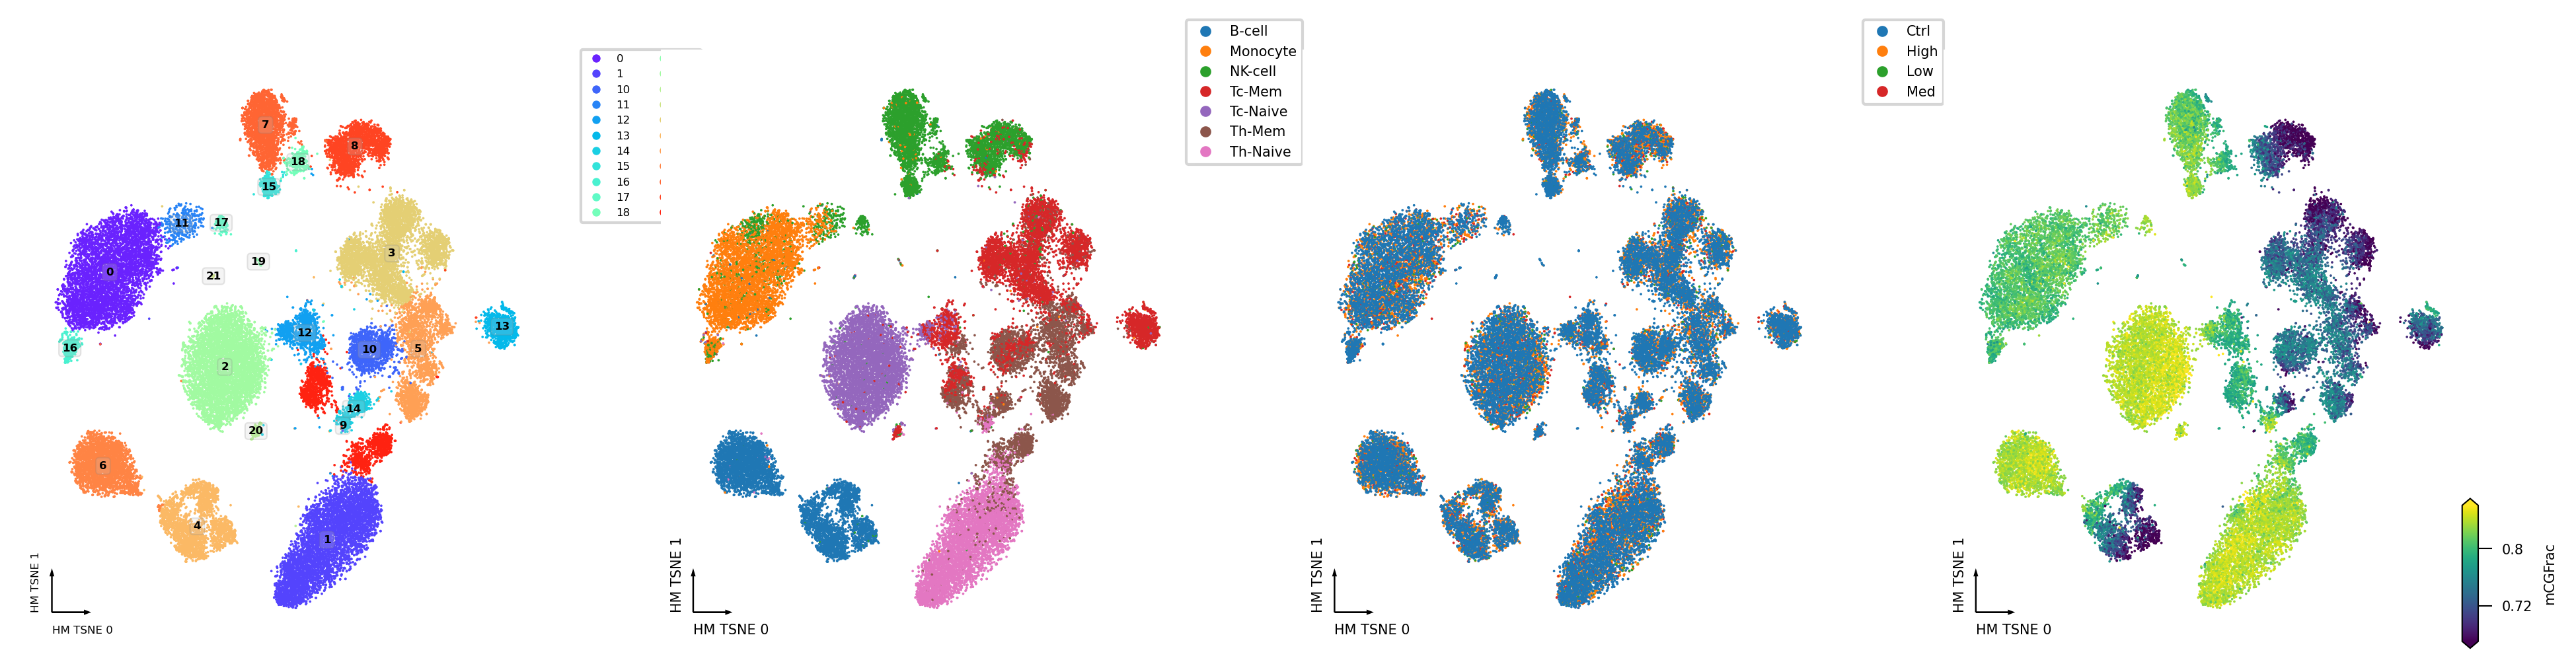

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
#                             legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                        text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='Level', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='mCGFrac', labelsize=5)
plt.savefig('All_cluster.pdf')

In [25]:
leiden2celltype = {7: 'NK-cell2',
                   15: 'NK-cell2',
                   18: 'NK-cell2',
                   8: 'NK-cell1',
                  6: 'B-Naive',
                  4: 'B-Mem'}

In [26]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['leiden'])] if int(row['leiden']) in leiden2celltype else row['cell_type'], axis=1)

/tmp/ipykernel_1695876/739378038.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['leiden'])] if int(row['leiden']) in leiden2celltype else row['cell_type'], axis=1)


In [27]:
mcad.write_h5ad('OP.Ctrl.All.TSNE.Annotation.mcad')

TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key 'Age' of <class 'h5py._hl.group.Group'> to /

In [ ]:
mcad.obs.to_csv("cell2cluster.csv")

In [2]:
metadata = pd.read_csv("cell2cluster.csv")

/tmp/ipykernel_3245698/1990708883.py:1: DtypeWarning: Columns (68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("cell2cluster.csv")


In [3]:
from collections import defaultdict, Counter

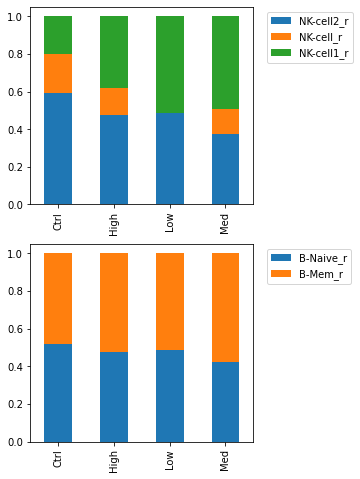

In [4]:
fig, axes = plt.subplots(2,1, figsize=(4,8))
count_list = list()
for i, celltype in enumerate(['NK-cell', 'B-cell']):
    cell_df = metadata[metadata['cell_type'] == celltype]
    count_dict = cell_df[['Level', 'annotation']].value_counts().to_dict()
    
    cell_counter = defaultdict(Counter)
    for (cond, cell) in count_dict:
        if count_dict[(cond, cell)] < 50:
            continue
        cell_counter[cond][cell] = count_dict[(cond, cell)]
        cell_counter[cond]['total'] += count_dict[(cond, cell)]
    cell_counter_df = pd.DataFrame.from_dict(cell_counter, orient='index')
    count_list.append(cell_counter_df)
    for cell in cell_counter_df.columns:
        if cell == 'total':
            continue
        cell_counter_df[f'{cell}_r'] = cell_counter_df.apply(lambda row: row[cell] / row['total'], axis=1)
    cell_counter_df[[x for x in cell_counter_df.columns if x.endswith("_r")]].sort_index().plot.bar(stacked=True, ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('OP_B-NK_ratio.pdf')

In [5]:
data_df = pd.concat(count_list, axis=1)

In [6]:
from scipy.stats import chi2_contingency

In [7]:
chi2_contingency(data_df.loc[['Ctrl', 'High','Low', 'Med'], ['B-Mem','B-Naive']])

(20.194240519508142,
 0.00015471323564582895,
 3,
 array([[1395.09620991, 1370.90379009],
        [ 803.97084548,  790.02915452],
        [ 131.13702624,  128.86297376],
        [ 264.79591837,  260.20408163]]))

In [10]:
chi2_contingency(data_df.loc[['Ctrl', 'High','Low', 'Med'], ['NK-cell2','NK-cell1']])

(262.28528198116845,
 1.4402840132473435e-56,
 3,
 array([[1447.57662218,  824.42337782],
        [ 884.34698573,  503.65301427],
        [ 142.71882191,   81.28117809],
        [ 294.35757018,  167.64242982]]))

In [5]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [6]:
metadata = metadata[metadata['cell_type']!='Other-cell']

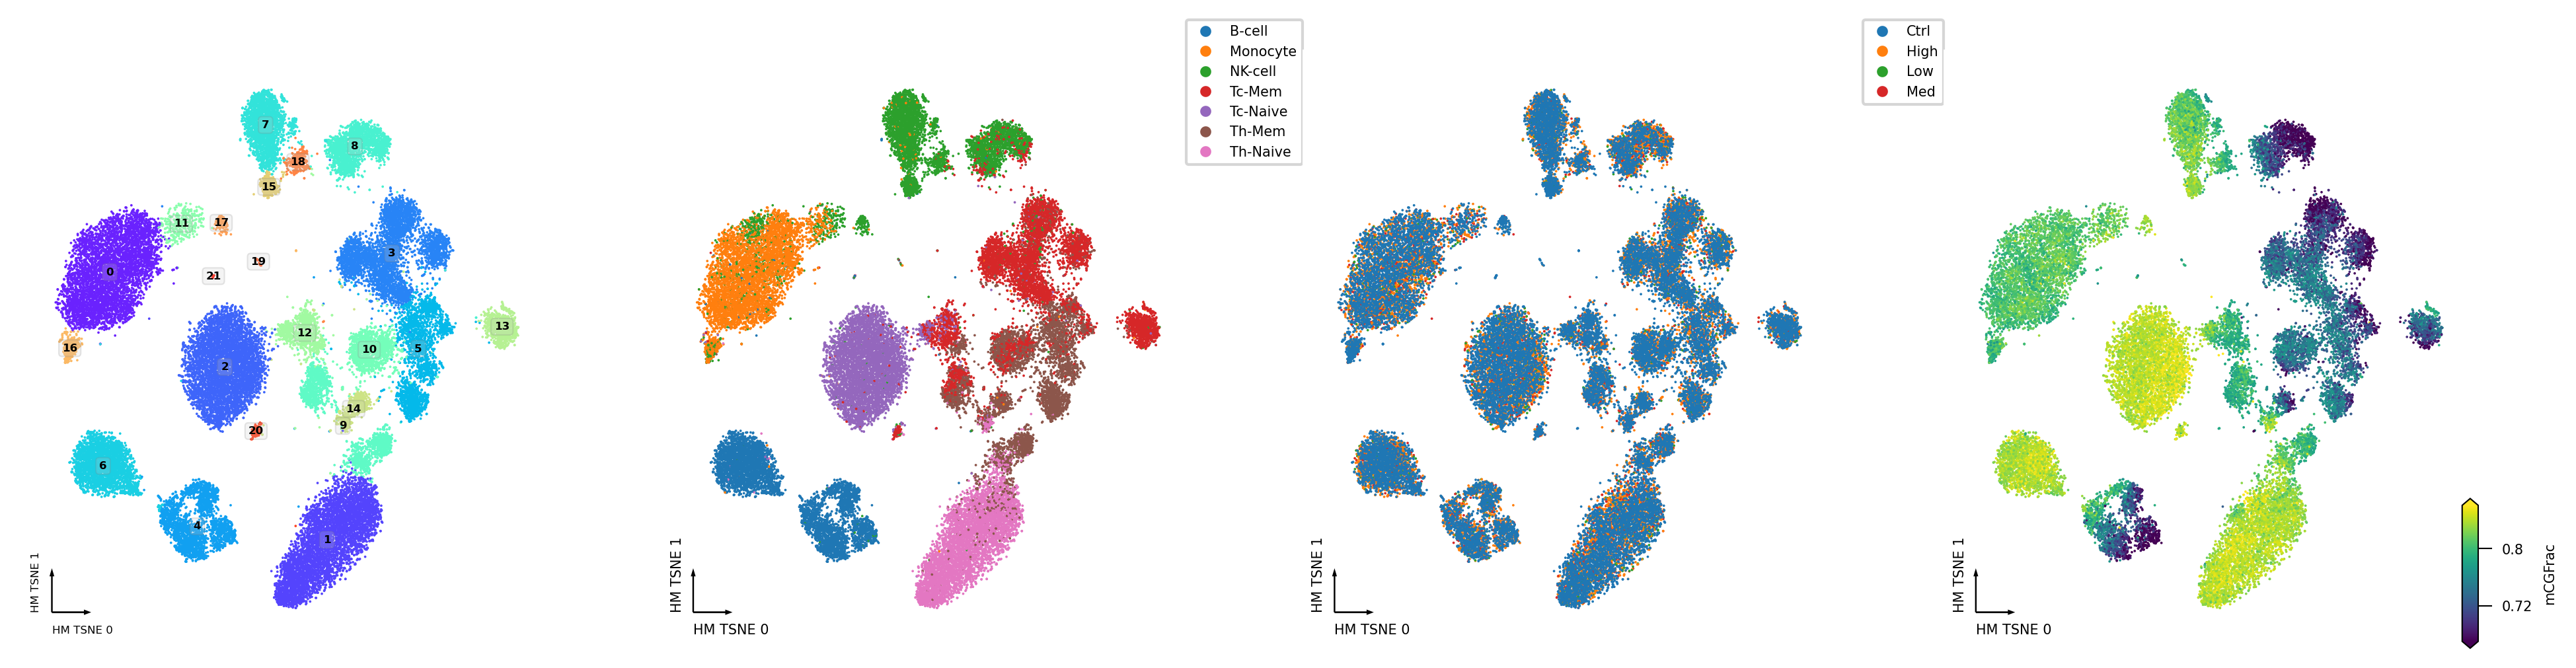

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=metadata, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=False, 
#                             legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                        text_anno="leiden")
_ = categorical_scatter(data=metadata, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=metadata, ax=axes[2], coord_base='HM_tsne', hue='Level', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=metadata, ax=axes[3], coord_base='HM_tsne', hue='mCGFrac', labelsize=5)
plt.savefig('All_cluster.pdf')

In [2]:
metadata = pd.read_csv("cell2cluster.csv")

/tmp/ipykernel_713051/1990708883.py:1: DtypeWarning: Columns (68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("cell2cluster.csv")


In [4]:
metadata.columns

Index(['cell', 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384',
       'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters',
       'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP',
       'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1MappingRate',
       'R1UnmappedReads', 'R1UnuniqueMappedReads', 'R1OT', 'R1OB', 'R1CTOT',
       'R1CTOB', 'R1TotalC', 'R1TotalmCGRate', 'R1TotalmCHGRate',
       'R1TotalmCHHRate', 'R1MAPQFilteredReads', 'R1DuplicatedReads',
       'R1DuplicationRate', 'R1FinalBismarkReads', 'R2InputReads',
       'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads',
       'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads',
       'R2MappingRate', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'R2OT',
       'R2OB', 'R2CTOT', 'R2CTOB', 'R2TotalC', 'R2TotalmCGRate',
       'R2TotalmCHGRate', 'R2TotalmCHHRate', 'R2MAPQFilteredReads',
       'R2DuplicatedReads', 'R2DuplicationRate', 'R2FinalBismarkReads',
       'mCHm

In [3]:
metadata['mCG_level'] = metadata.apply(lambda row: row.CG_Rate if str(row.mCGFrac)=='nan' else row.mCGFrac, axis=1)
metadata['mCH_level'] = metadata.apply(lambda row: row.CH_Rate if str(row.mCHFrac)=='nan' else row.mCHFrac, axis=1)

AttributeError: 'Series' object has no attribute 'CG_Rate'